In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the distorted image
image_path = "C:/Users/gbo10/OneDrive/measurement_paper_images/validation/GX010191_20_455.jpg""
distorted_img = cv2.imread(image_path)

# Camera matrix
K = np.array([
    [2484.910468620379, 0, 2655.131772934547],
    [0, 2486.158169901567, 1470.720703865392],
    [0, 0, 1]
], dtype=np.float32)

# Original distortion coefficients for fisheye (k1, k2, k3, k4)
original_D = np.array([1.33746652  ,0.01805018 , 1.68820471, -4.19502997,  4.26237896], dtype=np.float32)

# Scaling factor for distortion (0 = no undistortion, 1 = full undistortion)
lens_correction_amount = 0.5  # Adjust this value between 0 and 1 to control the amount of undistortion

# Calculate the correction factor
factor = (1.0 - lens_correction_amount).max(0.001)

# Adjust the focal length based on the correction factor
out_c = (K[0, 2], K[1, 2])  # Optical center
out_f = (K[0, 0] / factor, K[1, 1] / factor)  # Focal lengths

# Get image dimensions
h, w = distorted_img.shape[:2]

# Initialize the undistort rectify map with the adjusted focal length
new_camera_matrix = K.copy()
new_camera_matrix[0, 0] = out_f[0]
new_camera_matrix[1, 1] = out_f[1]

# Undistort the image
undistorted_img = cv2.fisheye.undistortImage(distorted_img, K, original_D, Knew=new_camera_matrix, new_size=(w, h))

# Display the original and undistorted images
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Original image
axs[0].imshow(cv2.cvtColor(distorted_img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Distorted Image')
axs[0].axis('on')

# Undistorted image
axs[1].imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
axs[1].set_title('Undistorted Image')
axs[1].axis('on')

plt.show()


AttributeError: 'float' object has no attribute 'max'

In [ ]:
import cv2
import numpy as np

# פונקציה לתיקון קואורדינטות פיקסלים מעוותות
def undistort_points(points, camera_matrix, dist_coeffs):
    points = np.array(points, dtype=np.float32)
    points = points.reshape(-1, 1, 2)
    undistorted_points = cv2.undistortPoints(points, camera_matrix, dist_coeffs, None, camera_matrix)
    undistorted_points = undistorted_points.reshape(-1, 2)
    return undistorted_points

# נתוני המדידה מתמונה מעוותת
distorted_points = [
    [x1, y1],
    [x2, y2],
    ...
]

# מטריצת המצלמה
camera_matrix = np.array([
    [2484.910468620379, 0, 2655.131772934547],
    [0, 2486.158169901567, 1470.720703865392],
    [0, 0, 1]
], dtype=np.float32)

# מקדמי העיוות
dist_coeffs = np.array([0.0342138895741646, 0.0676732076535786, -0.0740896999695528, 0.029944425491756], dtype=np.float32)

# תיקון הקואורדינטות
undistorted_points = undistort_points(distorted_points, camera_matrix, dist_coeffs)

print("קואורדינטות מתוקנות:")
print(undistorted_points)


In [1]:
import numpy as np
from scipy.optimize import least_squares

def fish_distort(p, theta):
    theta2 = theta * theta
    theta4 = theta2 * theta2
    theta6 = theta2 * theta4
    theta8 = theta4 * theta4
    return p[0] * theta * (1.0 + theta2 * p[1] + theta4 * p[2] + theta6 * p[3] + theta8 * p[4])

def fish_undistort_gradient(p, theta):
    theta2 = theta * theta
    theta4 = theta2 * theta2
    theta6 = theta2 * theta4
    theta8 = theta4 * theta4
    return np.array([
        theta * (1.0 + theta2 * p[1] + theta4 * p[2] + theta6 * p[3] + theta8 * p[4]),
        p[0] * theta * theta2,
        p[0] * theta * theta4,
        p[0] * theta * theta6,
        p[0] * theta * theta8
    ])

class Problem:
    STEP = 0.01

    def __init__(self, ior_ratio, max_ray_angle, params_orig):
        self.ior_ratio = ior_ratio
        self.max_ray_angle = max_ray_angle
        self.params_orig = params_orig

    def jacobian(self, param):
        n_pts = int(self.max_ray_angle / self.STEP)
        jac = np.vstack([
            fish_undistort_gradient(param, (i * self.STEP))
            for i in range(n_pts)
        ])
        return jac

    def apply(self, param):
        n_pts = int(self.max_ray_angle / self.STEP)
        residue = np.array([
            fish_distort(param, i * self.STEP) - fish_distort(self.params_orig, np.arcsin(np.sin(i * self.STEP) * self.ior_ratio))
            for i in range(n_pts)
        ])
        return residue

def recalc_for_underwater(params_orig, ior_ratio, tir_margin):
    max_ray_angle = np.arcsin(1.0 / ior_ratio) - tir_margin if ior_ratio > 1.0 else np.pi / 2.0
    problem = Problem(ior_ratio, max_ray_angle, params_orig)

    def fun(param):
        return problem.apply(param)

    def jac(param):
        return problem.jacobian(param)

    init_param = np.array(params_orig)
    result = least_squares(fun, init_param, jac=jac, max_nfev=10)

    if result.success:
        print(result)
        return result.x
    else:
        return None

def main():
    res = recalc_for_underwater(
        [
            1.0,                   # should be 1
           0.0342138895741646, 0.0676732076535786, -0.0740896999695528, 0.029944425491756,  # k3
        ],
        1.33, # water to air IOR ratio
        0.05, # margin around total internal reflection (radians)
    )
    print(res)

main()


     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 0.000e+00  7.444e-05 ...  6.139e-05 -3.259e-03]
           x: [ 1.337e+00  1.805e-02  1.688e+00 -4.195e+00  4.262e+00]
        cost: 2.0719672202576495e-05
         jac: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [ 1.000e-02  1.337e-06 ...  1.337e-14  1.337e-18]
               ...
               [ 9.946e-01  6.347e-01 ...  2.349e-01  1.429e-01]
               [ 1.024e+00  6.594e-01 ...  2.568e-01  1.603e-01]]
        grad: [ 7.926e-16  5.592e-16  3.597e-16  2.191e-16  1.297e-16]
  optimality: 7.925517880869037e-16
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
        nfev: 5
        njev: 5
[ 1.33746652  0.01805018  1.68820471 -4.19502997  4.26237896]


In [ ]:
import cv2
import numpy as np

# Assume 'rust_params' contains the 5 parameters from the Rust function
rust_params = [ 1.33746652 , 0.01805018 , 1.68820471 ,-4.19502997  ,4.26237896]
  # Example values

# Original camera matrix and distortion coefficients (for air)
K = np.array([[2484.910468620379, 0, 2655.131772934547],
    [0, 2486.158169901567, 1470.720703865392],
    [0, 0, 1]])
D = np.array([0.1, 0.01, 0.001, 0.0001])  # k1, k2, k3, k4 for air

# Apply focal length multiplier
K_underwater = K.copy()
K_underwater[0,0] *= rust_params[0]
K_underwater[1,1] *= rust_params[0]

# Image size
image_size = (640, 480)

# Estimate new camera matrix for underwater
new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(
    K_underwater, D, image_size, np.eye(3), balance=1.0)

# Use these for undistortion
map1, map2 = cv2.fisheye.initUndistortRectifyMap(
    K_underwater, D, np.eye(3), new_K, image_size, cv2.CV_32FC1)

# To undistort an image:
# undistorted = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

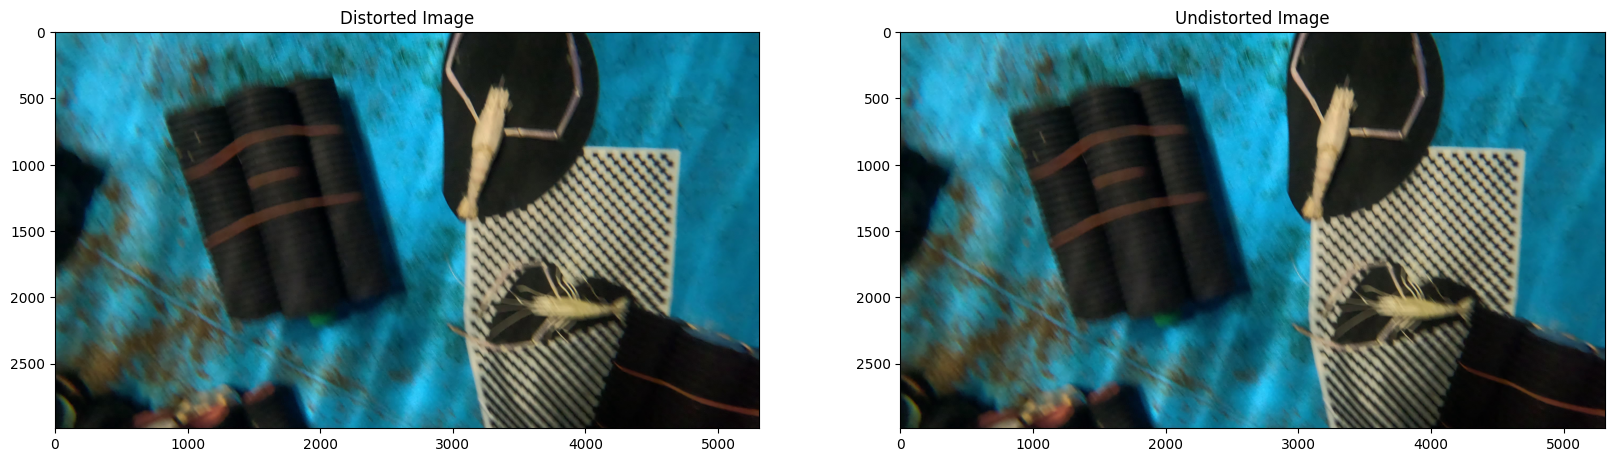

True

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the distorted image
image_path = "C:/Users/gbo10/OneDrive/measurement_paper_images/validation/GX010191_20_455.jpg"
distorted_img = cv2.imread(image_path)

# Camera matrix
K = np.array([
    [2484.910468620379, 0, 2655.131772934547],
    [0, 2486.158169901567, 1470.720703865392],
    [0, 0, 1]
], dtype=np.float32)

# Original distortion coefficients for fisheye (k1, k2, k3, k4)
original_D = np.array([0.0342138895741646, 0.0676732076535786, -0.0740896999695528, 0.029944425491756], dtype=np.float32)

# Scaling factor for distortion (0 = no undistortion, 1 = full undistortion)
lens_correction_amount = 1  # Adjust this value between 0 and 1 to control the amount of undistortion

# Calculate the correction factor
factor = max(1.0 - lens_correction_amount, 0.001)

# Adjust the focal length based on the correction factor
out_c = (K[0, 2], K[1, 2])  # Optical center
out_f = (K[0, 0] / factor, K[1, 1] / factor)  # Focal lengths

# Get image dimensions
h, w = distorted_img.shape[:2]

# Initialize the undistort rectify map with the adjusted focal length
new_camera_matrix = K.copy()
new_camera_matrix[0, 0] = out_f[0]
new_camera_matrix[1, 1] = out_f[1]

# Function to apply the Rust-like calculations for point correction
def correct_point(point, out_c, out_f, params):
    new_out_pos = point
    
    # Simulate digital lens undistortion if applicable (placeholder)
    # if has_digital_lens:
    #     new_out_pos = digital_lens_undistort(new_out_pos, params)
    
    # Scale and center the point
    new_out_pos = ((new_out_pos[0] - out_c[0]) / out_f[0], (new_out_pos[1] - out_c[1]) / out_f[1])
    
    # Apply distortion model (placeholder for actual distortion model logic)
    # new_out_pos = distortion_model_undistort(new_out_pos, params)
    
    # Correct for light refraction
    if params['light_refraction_coefficient'] != 1.0 and params['light_refraction_coefficient'] > 0.0:
        r = np.sqrt(new_out_pos[0]**2 + new_out_pos[1]**2)
        if r != 0.0:
            sin_theta_d = (r / np.sqrt(1.0 + r * r)) / params['light_refraction_coefficient']
            r_d = sin_theta_d / np.sqrt(1.0 - sin_theta_d * sin_theta_d)
            factor = r_d / r
            new_out_pos = (new_out_pos[0] * factor, new_out_pos[1] * factor)
    
    # Rescale and recenter the point
    new_out_pos = ((new_out_pos[0] * out_f[0]) + out_c[0], (new_out_pos[1] * out_f[1]) + out_c[1])
    
    # Blend the corrected point with the original point
    out_pos = (
        new_out_pos[0] * (1.0 - params['lens_correction_amount']) + (point[0] * params['lens_correction_amount']),
        new_out_pos[1] * (1.0 - params['lens_correction_amount']) + (point[1] * params['lens_correction_amount']),
    )
    
    return out_pos

# Parameters for correction
params = {
    'lens_correction_amount': lens_correction_amount,
    'light_refraction_coefficient': 1.33 # Adjust as needed
}

# Apply the point correction to the entire image
undistorted_img = np.zeros_like(distorted_img)
for i in range(h):
    for j in range(w):
        undistorted_point = correct_point((j, i), out_c, out_f, params)
        x, y = int(undistorted_point[0]), int(undistorted_point[1])
        if 0 <= x < w and 0 <= y < h:
            undistorted_img[y, x] = distorted_img[i, j]

# Display the original and undistorted images
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Original image
axs[0].imshow(cv2.cvtColor(distorted_img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Distorted Image')
axs[0].axis('on')

# Undistorted image
axs[1].imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
axs[1].set_title('Undistorted Image')
axs[1].axis('on')

plt.show()

#Save both images

cv2.imwrite('distorted_image.jpg', distorted_img)
cv2.imwrite('undistorted_image.jpg', undistorted_img)


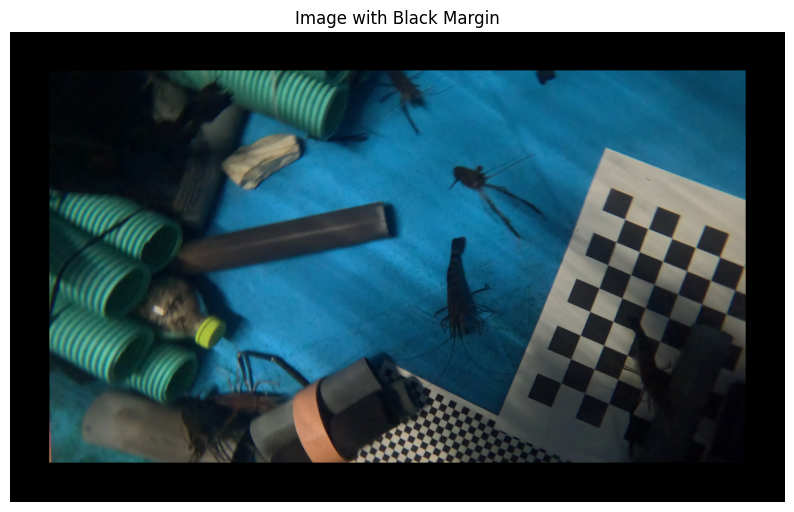

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image
image_path = "C:/Users/gbo10/OneDrive/measurement_paper_images/splitted videos/kalkar - january 2024/31.12/65/GX010065_9_258.jpg"
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print(f"Error: Could not load image at {image_path}")
else:
    # Define the size of the black margin (e.g., 50 pixels on each side)
    margin_size =300

    # Get the dimensions of the original image
    height, width = image.shape[:2]

    # Create a new image with a black margin
    new_height = height + 2 * margin_size
    new_width = width + 2 * margin_size
    image_with_margin = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    # Place the original image in the center of the new image
    image_with_margin[margin_size:margin_size+height, margin_size:margin_size+width] = image

    # Display the image with the black margin
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_with_margin, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Image with Black Margin')
    plt.show()



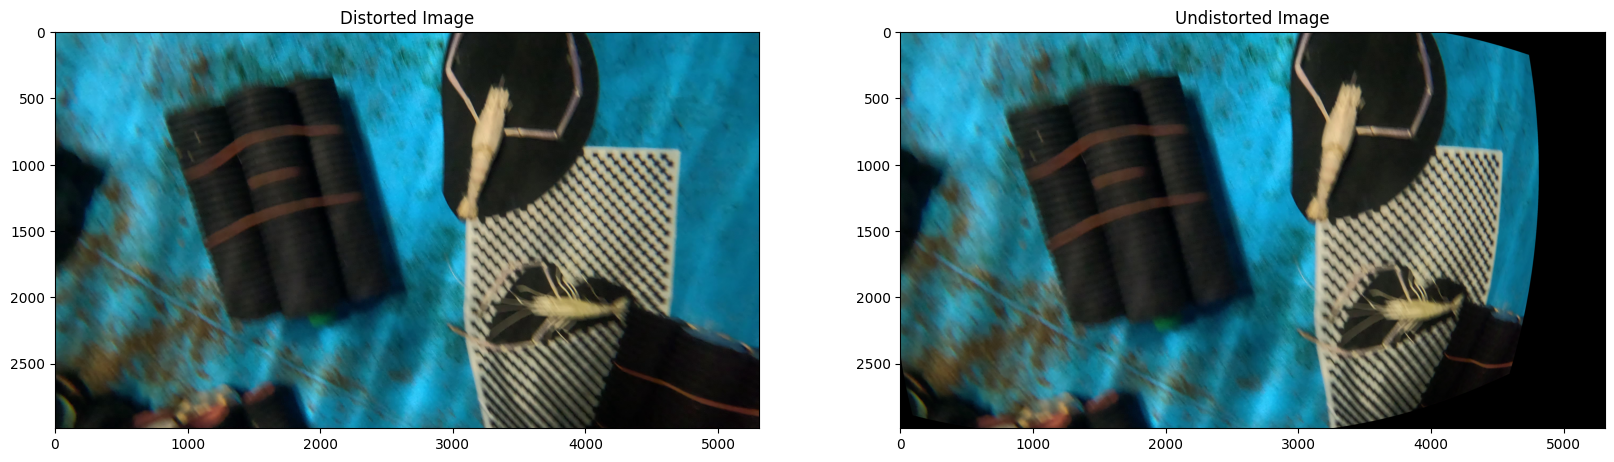

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the distorted image
image_path = "C:/Users/gbo10/OneDrive/measurement_paper_images/validation/GX010191_20_455.jpg"
distorted_img = cv2.imread(image_path)

# Camera matrix
K = np.array([
     
      [ 2404.59244190324, 0.0,              1919.372365976781 ],
      [ 0.0,                2405.799814606758, 1063.171593155705 ],
      [ 0.0,                0.0,              1.0 ]
    
], dtype=np.float32)

# Original distortion coefficients for fisheye (k1, k2, k3, k4)
original_D = np.array( [
      -0.00547109,  1.8530929,  -4.6149357,   4.6102057
    ], dtype=np.float32)



# Get image dimensions
h, w = distorted_img.shape[:2]

# Initialize the undistort rectify map with the adjusted focal length
new_camera_matrix = K.copy()


# Undistort the image
undistorted_img = cv2.fisheye.undistortImage(distorted_img, K, original_D, Knew=new_camera_matrix, new_size=(w, h))

# Display the original and undistorted images
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Original image
axs[0].imshow(cv2.cvtColor(distorted_img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Distorted Image')
axs[0].axis('on')

# Undistorted image
axs[1].imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
axs[1].set_title('Undistorted Image')
axs[1].axis('on')

plt.show()

In [17]:
#save both images
cv2.imwrite('distorted_img.jpg', distorted_img)
cv2.imwrite('undistorted_img.jpg', undistorted_img)


True

In [2]:
#calibrate from video
import cv2
import numpy as np

# Load the video file
video_path = "C:/Users/gbo10/Dropbox/research videos/car-current-/21.07.2024-calib/GX010199.MP4"
cap = cv2.VideoCapture(video_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print(f"Error: Could not open video at {video_path}")
else:
    # Define the number of frames to use for calibration
    num_frames = 2790

    # Initialize lists to store object points and image points
    obj_points = []
    img_points = []

    # Define the chessboard pattern size
    pattern_size = (3, 3)

    # Generate the object points for the chessboard pattern
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)

    # Loop through the video frames
    frame_count = 0
    while frame_count < num_frames:
        # Read a frame from the video
        ret, frame = cap.read()

        # Check if the frame was read successfully
        if not ret:
            break

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

        # If the corners are found, add the object points and image points
        if ret:
            print(f"Found corners in frame {frame_count}")
            obj_points.append(objp)
            img_points.append(corners)

            # Draw the corners on the frame
            frame = cv2.drawChessboardCorners(frame, pattern_size, corners, ret)

            # Increment the frame count
            frame_count += 1

        # Display the frame
        cv2.imshow('Frame', frame)

        # Check for the 'q' key to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()

    # Calibrate the camera using the object points and image points
    ret, K, D, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

    # Print the camera matrix and distortion coefficients
    print("Camera Matrix:")
    print(K)
    print("\nDistortion Coefficients:")
    print(D)



Found corners in frame 0
Found corners in frame 1
Found corners in frame 2
Found corners in frame 3
Found corners in frame 4
Found corners in frame 5
Found corners in frame 6
Found corners in frame 7
Found corners in frame 8


In [1]:
import json
from datetime import date
import numpy as np
import cv2
import glob
from tkinter import Tk
from tkinter.filedialog import askopenfilename

from scipy.spatial.transform import Rotation

import sys
from tqdm import tqdm

# https://www.imatest.com/support/docs/pre-5-2/geometric-calibration/projective-camera
def inverse_cam_mtx(K):
    # inverse for zero skew case
    if K.shape != (3,3):
        raise ValueError("Not 3x3 matrix")

    fx = K[0,0]
    fy = K[1,1]
    px = K[0,2]
    py = K[1,2]

    Kinv = np.array([[fy, 0,  -px*fy],
                     [0,  fx, -py*fx],
                     [0,  0,  fx*fy]])

    Kinv /= fx * fy

    return Kinv

class FisheyeCalibrator:
    """Class for calculating camera matrix and distortion coefficients
       from images or videoframes
       Mostly based on https://stackoverflow.com/a/50876130
       9x6 chessboard by default: https://raw.githubusercontent.com/opencv/opencv/master/doc/pattern.png
    """
    def __init__(self, chessboard_size=(9,6)):

        self.chessboard_size = chessboard_size

        # termination criteria
        self.subpix_criteria = (cv2.TERM_CRITERIA_EPS +
                                cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        self.calib_criteria = (cv2.TERM_CRITERIA_EPS +
                               cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)

        self.calibration_flags = (cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + # cv2.fisheye.CALIB_CHECK_COND +
                                  cv2.fisheye.CALIB_FIX_SKEW)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((chessboard_size[0] * chessboard_size[1],3), np.float32)
        self.objp[:,:2] = np.mgrid[0:chessboard_size[0],0:chessboard_size[1]].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d point in real world space
        self.imgpoints = [] # 2d points in image plane.

        # num images loaded
        self.num_images = 0

        # num images used in last calibration
        self.num_images_used = 0

        self.num_processed_images = 0

        self.first_image_processed = False
        # Equal if no stretching is applied
        self.orig_dimension = np.array([0, 0])
        self.calib_dimension = np.array([0, 0])

        # K & D (camera matrix and and distortion coefficients)
        self.K = np.zeros((3, 3))
        self.D = np.zeros((4, 1))

        # RMS error in pixels. Should be <1 after successful calibration
        self.RMS_error = 100

        # Horizontal stretching factor
        self.input_horizontal_stretch = 1

        self.data_from_preset_file = False

        # when loading a preset file
        self.extra_cam_info = None

    def new_calibration(self):
        self.objpoints = []
        self.imgpoints = []
        self.num_images = 0
        self.num_images_used = 0
        self.num_processed_images = 0

    def set_horizontal_stretch(self, new_stretch = 1):
        # For handling anamorphic or squeezed footage.
        self.input_horizontal_stretch = new_stretch

    def get_stretched_size_from_dimension(self, new_img_dim):
        return (round(new_img_dim[0] * self.calib_dimension[0] / self.orig_dimension[0]), round(new_img_dim[1] * self.calib_dimension[1] / self.orig_dimension[1]))

    def image_is_stretched(self):
        return self.input_horizontal_stretch != 1

    def get_stretched_size(self, img):
        h, w = img.shape[:2]

        if self.input_horizontal_stretch < 0:
            new_h = round(h / self.input_horizontal_stretch)
            new_w = w
        else:
            new_w = round(w * self.input_horizontal_stretch)
            new_h = h

        return (new_w, new_h)

    def stretch_image(self, img):
        if self.input_horizontal_stretch == 1:
            return img

        # 16:9 to 4:3 gives input_horizontal_stretch of
        # (4/3)/(16/9) = 0.75

        h, w = img.shape[:2]

        if self.input_horizontal_stretch < 0:
            new_h = round(h / self.input_horizontal_stretch)
            new_w = w
        else:
            new_w = round(w * self.input_horizontal_stretch)
            new_h = h

        return cv2.resize(img, (new_w, new_h))


    def add_calib_image(self, img):
        """Add chessboard image for calibration

        Args:
            img (np.ndarray): Image or video frame

        Returns:
            (bool, string, np.ndarray): (success, status message, corners)
        """

        if self.data_from_preset_file:
            raise Exception("Preset already loaded from file")


        if self.num_images == 0:
            # save the dimensions of the first image [width, height]
            self.orig_dimension = img.shape[:2][::-1]
            self.calib_dimension = self.get_stretched_size(img)


        # check image dimension
        if img.shape[:2][::-1] != self.orig_dimension:
            return (False, "Image dimension doesn't match previous samples", None)



        gray = cv2.cvtColor(self.stretch_image(img),cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, self.chessboard_size, None)

        if not ret:
            return (False, "Failed to detect chessboard", None)


        # If found, add object points, image points (after refining them)
        self.num_images += 1
        self.objpoints.append(self.objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),self.subpix_criteria)
        # print(corners2)


        # horizontal scaling

        self.imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners2,ret)
        #scaled = cv2.resize(img, (960,720))
        #cv2.imshow('img',scaled)
        #cv2.waitKey(500)

        corners_orig = np.copy(corners2)

        if self.image_is_stretched():
            # Transform back to original image format
            corners_orig[:,:,0] *= self.orig_dimension[0] / self.calib_dimension[0] # x axis
            corners_orig[:,:,1] *= self.orig_dimension[1] / self.calib_dimension[1] # y axis

        return (True, "Image processed and added", corners_orig)

    def remove_calib_image(self):
        """Remove last added calibration image
        """
        if self.num_images > 0:
            self.objpoints.pop(-1)
            self.imgpoints.pop(-1)
            self.num_images -= 1

    def compute_calibration(self, center_camera=True):
        """Compute camera calibration from loaded images

        Args:
            center_camera (bool): center camera matrix after calib.

        Raises:
            Exception: No calibration frames/data

        Returns:
            float: Calibration RMS pixel error. <1 is great
        """

        if self.num_images == 0:
            raise Exception("No calibration data")

        # recompute only if new images added
        # if self.num_images_used == self.num_images:
        #     return self.RMS_error

        num_corners = self.chessboard_size[0]*self.chessboard_size[1]

        temp_objpoints = np.asarray(self.objpoints,dtype=np.float64)
        temp_objpoints = np.reshape(self.objpoints, (self.num_images, 1, num_corners, 3))

        temp_imgpoints = np.asarray(self.imgpoints,dtype=np.float64)
        temp_imgpoints = np.reshape(self.imgpoints, (self.num_images, 1, num_corners, 2))

        rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(self.num_images)]
        tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(self.num_images)]

        try:
            retval, self.K, self.D, rvecs, tvecs = cv2.fisheye.calibrate(temp_objpoints,
                    temp_imgpoints,
                    self.calib_dimension,
                    self.K,
                    self.D,
                    rvecs,
                    tvecs,
                    self.calibration_flags,
                    self.calib_criteria)
        except:
            print("Error computing calibration, remove a frame and try again")
            return 100

        if center_camera:
            self.K[0,2] = self.calib_dimension[0]/2
            self.K[1,2] = self.calib_dimension[1]/2

        self.RMS_error = retval
        self.num_images_used = self.num_images

        return self.RMS_error


    def get_camera_matrix(self):
        """Get camera matrix from calibration

        Returns:
            np.ndarray: Camera matrix (K)
        """
        self.compute_calibration()

        return self.K

    def get_inverse_camera_matrix(self):
        self.compute_calibration()

        return inverse_cam_mtx(self.K)

    def get_distortion_coefficients(self):
        """Get distortion coefficients from calibration

        Returns:
            np.ndarray: distortion coefficients (D)
        """
        self.compute_calibration()

        return self.D

    def get_rms_error(self):
        """Get the calibration rms error

        Returns:
            float: Calibration RMS pixel error. should be <1.
        """
        return self.compute_calibration()


    def undistort_image(self, img, fov_scale=1.0):
        """Undistort image using the fisheye camera model in OpenCV

        Args:
            img (np.ndarray): Input image
            fov_scale (float, optional): Virtual camera focal length divider. Defaults to 1.

        Returns:
            np.ndarray: Undistorted image
        """

        self.compute_calibration()

        img_dim = img.shape[:2][::-1]

        scaled_K = self.K * img_dim[0] / self.calib_dimension[0]
        scaled_K[2][2] = 1.0

        new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, self.D,
                img_dim, np.eye(3), fov_scale=fov_scale)

        self.new_K = new_K

        #print("FOV BEFORE: {}".format(scaled_K[0,0]))
        #print("FOV EFTER: {}".format(new_K[0,0]))

        map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, self.D, np.eye(3), new_K, img_dim, cv2.CV_16SC2)


        undistorted_image = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_CONSTANT)

        return undistorted_image

    def get_maps(self, fov_scale = 1.0, output_dim = None, new_img_dim = None, update_new_K = True, quat = None, focalCenter = None, original_stretched = True):
        """Get undistortion maps

        Args:
            fov_scale (float, optional): Virtual camera focal length divider. Defaults to 1.
            new_img_dim (tuple, optional): Dimension of new image

        Returns:
            (np.ndarray,np.ndarray): Undistortion maps
        """

        if new_img_dim and self.image_is_stretched() and original_stretched:
            # new_img_dim is dimension of unstretched image
            new_img_dim = (round(new_img_dim[0] * self.calib_dimension[0] / self.orig_dimension[0]), round(new_img_dim[1] * self.calib_dimension[1] / self.orig_dimension[1]))

        img_dim = new_img_dim if new_img_dim else self.calib_dimension
        out_dim = output_dim if output_dim else self.calib_dimension
        focalCenter = focalCenter if focalCenter is not None else np.array([self.calib_dimension[0]/2,self.calib_dimension[1]/2])

        R = np.eye(3)

        if type(quat) != type(None):
            quat = quat.flatten()
            #R = Rotation([-quat[1],-quat[2],quat[3],-quat[0]]).as_matrix()
            R = Rotation([quat[1],quat[2],quat[3],quat[0]]).as_matrix()

            R[[0,0,1,2],[1,2,0,0]] *=-1
            #final_rotation = np.eye(3)
            #final_rotation[0,0] = -1
            #R = np.linalg.multi_dot([np.linalg.inv(final_rotation), R, final_rotation])

        img_dim_ratio = img_dim[0] / self.calib_dimension[0]

        scaled_K = self.K * img_dim_ratio
        scaled_K[2][2] = 1.0

        new_K = np.copy(self.K)
        new_K[0][0] = new_K[0][0] * 1.0/fov_scale
        new_K[1][1] = new_K[1][1] * 1.0/fov_scale
        new_K[0][2] = (self.calib_dimension[0]/2 - focalCenter[0])* img_dim_ratio/fov_scale + out_dim[0]/2
        new_K[1][2] = (self.calib_dimension[1]/2 - focalCenter[1])* img_dim_ratio/fov_scale + out_dim[1]/2

        if update_new_K:
            self.new_K = new_K
        
        if original_stretched and self.image_is_stretched():
            map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, self.D, R, new_K, out_dim, cv2.CV_32FC1)
            # Rescale input and convert to int for speed
            map1, map2 = cv2.convertMaps(map1 * self.orig_dimension[0] / self.calib_dimension[0], map2 * self.orig_dimension[1] / self.calib_dimension[1], cv2.CV_16SC2)
            
            return map1, map2

        else:
            map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, self.D, R, new_K, out_dim, cv2.CV_16SC2)
            return map1, map2



    def undistort_points(self, distorted_points,new_img_dim = None):
        img_dim = new_img_dim if new_img_dim else self.calib_dimension

        scaled_K = self.K * img_dim[0] / self.calib_dimension[0]
        scaled_K[2][2] = 1.0

        pts = cv2.fisheye.undistortPoints(distorted_points, scaled_K, self.D, None, scaled_K)

        return pts if type(pts) != type(None) else np.array([])

    def decompose_homography(self, H, new_img_dim = None):
        img_dim = new_img_dim if new_img_dim else self.calib_dimension

        scaled_K = self.K * img_dim[0] / self.calib_dimension[0]
        scaled_K[2][2] = 1.0
        return cv2.decomposeHomographyMat(H, scaled_K)


    def recover_pose(self, pts1, pts2, new_img_dim = None):
        """ Find rotation matrices using epipolar geometry
        
        Args:
            pts1 (np.ndarray): Initial points
            pts2 (np.ndarray): Resulting points
            new_img_dim (tuple, optional): New image dimension. Defaults to None.

        Returns:
            [type]: [description]
        """
        # https://answers.opencv.org/question/31421/opencv-3-essentialmatrix-and-recoverpose/
        img_dim = new_img_dim if new_img_dim else self.calib_dimension
        scaled_K = self.K * img_dim[0] / self.calib_dimension[0]
        scaled_K[2][2] = 1.0

        E, mask = cv2.findEssentialMat(pts1, pts2, scaled_K, cv2.RANSAC, 0.999, 0.1) # cv2.LMEDS or cv2.RANSAC
        #retval, R, t, mask = cv2.recoverPose(E, pts1, pts2, scaled_K)
        try:
            R1, R2, t = cv2.decomposeEssentialMat(E)
        except:
            # Can't figure it out, assume no rotation
            return np.eye(3), np.eye(3), np.array([0,0,0])
        return R1, R2, t

    def get_rotation_map(self, img, quat):
        """Get maps for doing perspective rotations

            WORK IN PROGRESS. Currently for testing
        """

        # https://stackoverflow.com/a/12293128
        # https://en.wikipedia.org/wiki/Homography_(computer_vision)

        rotXval = 0
        rotYval = 0
        rotZval = 0

        rotX = (rotXval)*np.pi/180
        rotY = (rotYval)*np.pi/180
        rotZ = (rotZval)*np.pi/180
        rot_mat = np.eye(4)

        #print(Rotation([quat[0,1],quat[0,2],quat[0,3],quat[0,0]]).as_euler('xyz'))
        quat = quat.flatten()
        eul = Rotation([quat[1],quat[2],quat[3],quat[0]]).as_euler('xyz')

        combined_rotation = np.eye(4)
        #combined_rotation[0:3,0:3] = Rotation.from_euler('xyz', [eul[0], eul[1], -eul[2]], degrees=False).as_matrix()
        combined_rotation[0:3,0:3] = Rotation([-quat[1],-quat[2],quat[3],-quat[0]]).as_matrix()

        rot_mat = combined_rotation
        img_dim = img.shape[:2][::-1]

        # Scaled 3x4 camera matrix
        K = np.zeros((3,4))
        K[:3,:3] = self.K

        # should make the rotation match fov change
        K[0,0] = self.new_K[0,0]
        K[1,1] = self.new_K[1,1]

        K *= img_dim[0] / self.calib_dimension[0]

        K[2][2] = 1.0

        # compute inverse camera matrix using scaled K
        Kinv = np.zeros((4,3))
        Kinv[0:3,0:3] = inverse_cam_mtx(K[:3,:3])
        Kinv[3,:] = [0, 0, 1]

        H = np.linalg.multi_dot([K, rot_mat, Kinv])

        #transform = self.K * trans
        outimg = cv2.warpPerspective(img,H,(img.shape[1],img.shape[0]))
        return outimg

    def get_calibration_data(self):


        calibration_data = {
            "name": self.extra_cam_info.get("name", ""),
            "note": self.extra_cam_info.get("note", ""),
            "calibrated_by": self.extra_cam_info.get("calibrated_by", "N/A"),
            "camera_brand": self.extra_cam_info.get("camera_brand", "N/A"),
            "camera_model": self.extra_cam_info.get("camera_model", "N/A"),
            "lens_model": self.extra_cam_info.get("lens_model", "N/A"),
            "camera_setting": self.extra_cam_info.get("camera_setting", "N/A"),
            "calibrator_version": self.extra_cam_info.get("calibrator_version", "N/A"),
            "date": self.extra_cam_info.get("date", "N/A"),
            "calib_dimension": {
                "w": self.calib_dimension[0],
                "h": self.calib_dimension[1]
            },
            "orig_dimension": {
                "w": self.orig_dimension[0],
                "h": self.orig_dimension[1]
            },
            "input_horizontal_stretch": self.input_horizontal_stretch, # to de-stretch anamorphic/linearly stretched video.
            "num_images": self.num_images_used,

            "use_opencv_fisheye": True,
            "fisheye_params": {
                "RMS_error": self.RMS_error,
                "camera_matrix": self.K.tolist(),
                "distortion_coeffs": self.D.flatten().tolist()
            },
            # For (potential) use with the standard cv2.calibrateCamera
            "use_opencv_standard": False,
            "calib_params": {}
        }

        return calibration_data

    def load_calibration_data(self, cal_data, printinfo = False):

        try:
            if not cal_data["use_opencv_fisheye"]:
                raise Exception("Preset not for OpenCV fisheye lens model")

            self.data_from_preset_file = True

            if printinfo:
                print("Preset name: {}".format(cal_data["name"]))
                print("Note: {}".format(cal_data["note"]))
                print("Made with {} frames using calibrator version {} on date {}"
                    .format(cal_data["num_images"],
                            cal_data["calibrator_version"],
                            cal_data["date"]))

            if cal_data["calibrator_version"] != __version__:
                print("Note: Versions don't match. Calibrator: {}, Preset: {}. Should be fine though."
                    .format(__version__, cal_data["calibrator_version"]))

            cal_width = cal_data["calib_dimension"]["w"]
            cal_height = cal_data["calib_dimension"]["h"]

            self.calib_dimension = (cal_width, cal_height)

            # Added in 0.3.0
            if "orig_dimension" in cal_data:
                orig_w = cal_data["orig_dimension"]["w"]
                orig_h = cal_data["orig_dimension"]["h"]
                self.input_horizontal_stretch = cal_data["input_horizontal_stretch"]
                self.orig_dimension = (orig_w, orig_h)
            else:
                self.input_horizontal_stretch = 1
                self.orig_dimension = self.calib_dimension


            self.num_images = self.num_images_used = cal_data["num_images"]

            self.RMS_error = cal_data["fisheye_params"]["RMS_error"]
            self.K = np.array(cal_data["fisheye_params"]["camera_matrix"])
            self.D = np.array(cal_data["fisheye_params"]["distortion_coeffs"])

            #if presets["calibrator_version"].split(".")[0:1] != ["0","1"]:
            # version 0.1.x doesn't have cam information

            fixed_name = " ".join(cal_data.get("name").replace("_", " ").split())

            self.extra_cam_info = {
                "name": fixed_name,
                "note": cal_data.get("note"),
                "calibrated_by": cal_data.get("calibrated_by", "N/A"),
                "camera_brand": cal_data.get("camera_brand", "N/A"),
                "camera_model": cal_data.get("camera_model", "N/A"),
                "camera_setting": cal_data.get("camera_setting", "N/A"),
                "lens_model": cal_data.get("lens_model", "N/A"),
                "calibrator_version": cal_data.get("calibrator_version"),
                "date": cal_data.get("date"),
                "width": self.orig_dimension[0],
                "height": self.orig_dimension[1],
                "aspect": self.orig_dimension[0]/self.orig_dimension[1],
                "num_images": self.num_images
            }

        except ZeroDivisionError:
            raise KeyError("Error loading preset file")
        

        return self.extra_cam_info

    def save_calibration_json(self, filename="calibration.json", calib_name="Camera name", camera_brand="", camera_model="", lens_model="", camera_setting="", note="", calibrated_by=""):
        """Save camera calibration parameters as JSON file

        Args:
            filename (str, optional): Path and name of file. Defaults to "calibration.json".
            calib_name (str, optional): Calibration name in file. Defaults to "Camera name".
            note (str, optional): Extra note, calibration setup, calibrator name etc.
        """

        self.compute_calibration()

        calibration_data = {
            "name": calib_name,
            "note": note,
            "calibrated_by": calibrated_by,
            "camera_brand": camera_brand,
            "camera_model": camera_model,
            "lens_model": lens_model,
            "camera_setting": camera_setting,
            "calibrator_version": 'd',
            "date": str(date.today()),

            "calib_dimension": {
                "w": self.calib_dimension[0],
                "h": self.calib_dimension[1]
            },
            "orig_dimension": {
                "w": self.orig_dimension[0],
                "h": self.orig_dimension[1]
            },
            "input_horizontal_stretch": self.input_horizontal_stretch, # to de-stretch anamorphic/linearly stretched video.
            "num_images": self.num_images_used,

            "use_opencv_fisheye": True,
            "fisheye_params": {
                "RMS_error": self.RMS_error,
                "camera_matrix": self.K.tolist(),
                "distortion_coeffs": self.D.flatten().tolist()
            },
            # For (potential) use with the standard cv2.calibrateCamera
            "use_opencv_standard": False,
            "calib_params": {}
        }

        with open(filename, 'w') as outfile:
            json.dump(
            calibration_data,
            outfile,
            indent=4,
            separators=(',', ': ')
        )


    def load_calibration_json(self, filename, printinfo = False):
        """Load calibration preset from JSON file

        Args:
            filename (string): path and filename to load
            printinfo (bool, optional): Print extra info from preset file. Defaults to False.
        """
        with open(filename, "r") as infile:
            presets = json.load(infile)

            return self.load_calibration_data(presets, printinfo)


    def load_calibration_prompt(self, printinfo = False):
        """Trigger file browser to load calibration preset

        Args:
            printinfo (bool, optional): Print extra info from preset file. Defaults to False.
        """

        Tk().withdraw() # hide root window
        # file browser prompt
        filename = askopenfilename(title = "Select calibration preset file",
                                   filetypes = (("JSON files","*.json"),))

        self.load_calibration_json(filename, printinfo)

    def undistort_image_prompt(self, fov_scale=1):
        """Trigger file browser to load and undistort image

        Args:
            fov_scale (float, optional): Virtual camera focal length divider. Defaults to 1.
        """
        self.compute_calibration()

        Tk().withdraw()

        filename = askopenfilename(title = "Select image to undistort",
                                   filetypes = (("jpeg images","*.jpg"),("png images","*.png")))

        raw_img = cv2.imread(filename)

        undistorted_img = self.undistort_image(raw_img, fov_scale=1)


        for i in range(5):

            rotated_img = self.get_rotation_map(undistorted_img,30)
            scaled = cv2.resize(rotated_img, (960,720))
            cv2.imshow('OpenCV image viewer',scaled)
            cv2.waitKey(500)


            rotated_img = self.get_rotation_map(undistorted_img,0)
            scaled = cv2.resize(rotated_img, (960,720))
            cv2.imshow('OpenCV image viewer',scaled)
            cv2.waitKey(500)


class StandardCalibrator:
    """Class for calculating camera matrix and distortion coefficients
       from images or videoframes
       Mostly based on https://stackoverflow.com/a/50876130
       9x6 chessboard by default: https://raw.githubusercontent.com/opencv/opencv/master/doc/pattern.png
    """
    def __init__(self, chessboard_size=(9,6)):

        self.chessboard_size = chessboard_size

        # termination criteria
        self.subpix_criteria = (cv2.TERM_CRITERIA_EPS +
                                cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        self.calib_criteria = (cv2.TERM_CRITERIA_EPS +
                               cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)

        self.calibration_flags = (cv2.CALIB_SAME_FOCAL_LENGTH +
                                  cv2.CALIB_RATIONAL_MODEL +
                                  cv2.CALIB_FIX_PRINCIPAL_POINT +
                                  cv2.CALIB_USE_INTRINSIC_GUESS +
                                  cv2.CALIB_TILTED_MODEL)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((chessboard_size[0] * chessboard_size[1],3), np.float32)
        self.objp[:,:2] = np.mgrid[0:chessboard_size[0],0:chessboard_size[1]].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d point in real world space
        self.imgpoints = [] # 2d points in image plane.

        # num images loaded
        self.num_images = 0

        # num images used in last calibration
        self.num_images_used = 0

        self.first_image_processed = False
        self.calib_dimension = np.array([0, 0])

        # K & D (camera matrix and and distortion coefficients)
        self.K = np.zeros((3, 3))
        self.D = np.zeros((4, 1))

        # RMS error in pixels. Should be <1 after successful calibration
        self.RMS_error = 100

        self.data_from_preset_file = False



    def add_calib_image(self, img):
        """Add chessboard image for calibration

        Args:
            img (np.ndarray): Image or video frame

        Returns:
            (bool, string, np.ndarray): (success, status message, corners)
        """

        if self.data_from_preset_file:
            raise Exception("Preset already loaded from file")


        if not self.first_image_processed:
            # save the dimensions of the first image [width, height]
            self.calib_dimension = img.shape[:2][::-1]


        # check image dimension
        if img.shape[:2][::-1] != self.calib_dimension:
            return (False, "Image dimension doesn't match previous samples", None)


        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, self.chessboard_size, None)

        if not ret:
            return (False, "Failed to detect chessboard", None)


        # If found, add object points, image points (after refining them)
        self.num_images += 1
        self.objpoints.append(self.objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),self.subpix_criteria)
        self.imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners2,ret)
        #scaled = cv2.resize(img, (960,720))
        #cv2.imshow('img',scaled)
        #cv2.waitKey(500)
        return (True, "Image processed and added", corners2)

    def remove_calib_image(self):
        """Remove last added calibration image
        """
        if self.num_images > 0:
            self.objpoints.pop(-1)
            self.imgpoints.pop(-1)
            self.num_images -= 1

    def compute_calibration(self, center_camera=True):
        """Compute camera calibration from loaded images

        Args:
            center_camera (bool): center camera matrix after calib.

        Raises:
            Exception: No calibration frames/data

        Returns:
            float: Calibration RMS pixel error. <1 is great
        """

        if self.num_images == 0:
            raise Exception("No calibration data")

        # recompute only if new images added
        # if self.num_images_used == self.num_images:
        #     return self.RMS_error

        num_corners = self.chessboard_size[0]*self.chessboard_size[1]

        temp_objpoints = np.asarray(self.objpoints,dtype=np.float64)
        temp_objpoints = np.reshape(self.objpoints, (self.num_images, 1, num_corners, 3))

        temp_imgpoints = np.asarray(self.imgpoints,dtype=np.float64)
        temp_imgpoints = np.reshape(self.imgpoints, (self.num_images, 1, num_corners, 2))

        rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(self.num_images)]
        tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(self.num_images)]

        self.K = np.array(
        [
                    [
                        1000,
                        0.0,
                        self.calib_dimension[0]/2
                    ],
                    [
                        0.0,
                        1000,
                        self.calib_dimension[1]/2
                    ],
                    [
                        0.0,
                        0.0,
                        1.0
                    ]
                ]
        )

        retval, self.K, self.D, rvecs, tvecs = cv2.calibrateCamera(temp_objpoints,
                temp_imgpoints,
                self.calib_dimension,
                self.K,
                self.D,
                rvecs,
                tvecs,
                self.calibration_flags,
                self.calib_criteria)

        if center_camera:
            self.K[0,2] = self.calib_dimension[0]/2
            self.K[1,2] = self.calib_dimension[1]/2

        self.RMS_error = retval
        self.num_images_used = self.num_images

        return self.RMS_error


    def get_camera_matrix(self):
        """Get camera matrix from calibration

        Returns:
            np.ndarray: Camera matrix (K)
        """
        self.compute_calibration()

        return self.K

    def get_inverse_camera_matrix(self):
        self.compute_calibration

        return inverse_cam_mtx(self.K)

    def get_distortion_coefficients(self):
        """Get distortion coefficients from calibration

        Returns:
            np.ndarray: distortion coefficients (D)
        """
        self.compute_calibration()

        return self.D

    def get_rms_error(self):
        """Get the calibration rms error

        Returns:
            float: Calibration RMS pixel error. should be <1.
        """
        return self.compute_calibration()


    def undistort_image(self, img, fov_scale=1.0):
        """Undistort image using the fisheye camera model in OpenCV

        Args:
            img (np.ndarray): Input image
            fov_scale (float, optional): Virtual camera focal length divider. Defaults to 1.

        Returns:
            np.ndarray: Undistorted image
        """

        self.compute_calibration()

        img_dim = img.shape[:2][::-1]

        scaled_K = self.K * img_dim[0] / self.calib_dimension[0]
        scaled_K[2][2] = 1.0

        new_K, _ = cv2.getOptimalNewCameraMatrix(scaled_K, self.D,
                img_dim, 1.3, img_dim)

        self.new_K = new_K

        #print("FOV BEFORE: {}".format(scaled_K[0,0]))
        #print("FOV EFTER: {}".format(new_K[0,0]))

        map1, map2 = self.get_maps()


        undistorted_image = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_CONSTANT)

        return undistorted_image

    def get_maps(self, fov_scale = 1.0, new_img_dim = None):
        """Get undistortion maps

        Args:
            fov_scale (float, optional): Virtual camera focal length divider. Defaults to 1.
            new_img_dim (tuple, optional): Dimension of new image

        Returns:
            (np.ndarray,np.ndarray): Undistortion maps
        """

        img_dim = new_img_dim if new_img_dim else self.calib_dimension

        scaled_K = self.K * img_dim[0] / self.calib_dimension[0]
        scaled_K[2][2] = 1.0

        new_K, _ = cv2.getOptimalNewCameraMatrix(scaled_K, self.D,
                img_dim, 1.3, img_dim)


        self.new_K = new_K
        print(new_K)


        map1, map2 = cv2.initUndistortRectifyMap(scaled_K, self.D, np.eye(3), new_K, img_dim, cv2.CV_16SC2)

        return map1, map2


    def undistort_points(self, distorted_points,new_img_dim = None):
        img_dim = new_img_dim if new_img_dim else self.calib_dimension

        scaled_K = self.K * img_dim[0] / self.calib_dimension[0]
        scaled_K[2][2] = 1.0


        return cv2.undistortPoints(distorted_points, scaled_K, self.D, None, scaled_K)

    def decompose_homography(self, H, new_img_dim = None):
        img_dim = new_img_dim if new_img_dim else self.calib_dimension

        scaled_K = self.K * img_dim[0] / self.calib_dimension[0]
        scaled_K[2][2] = 1.0
        return cv2.decomposeHomographyMat(H, scaled_K)


    def recover_pose(self, pts1, pts2, new_img_dim = None):
        # https://answers.opencv.org/question/31421/opencv-3-essentialmatrix-and-recoverpose/
        # Find essential matrix from fundamental matrix
        img_dim = new_img_dim if new_img_dim else self.calib_dimension
        scaled_K = self.K * img_dim[0] / self.calib_dimension[0]
        scaled_K[2][2] = 1.0

        E, mask = cv2.findEssentialMat(pts1, pts2, scaled_K, cv2.RANSAC, 0.999, 0.1) # cv2.LMEDS or cv2.RANSAC
        #retval, R, t, mask = cv2.recoverPose(E, pts1, pts2, scaled_K)
        R1, R2, t = cv2.decomposeEssentialMat(E)

        return R1, R2, t

    def get_rotation_map(self, img, quat):
        """Get maps for doing perspective rotations

            WORK IN PROGRESS. Currently for testing
        """

        # https://stackoverflow.com/a/12293128
        # https://en.wikipedia.org/wiki/Homography_(computer_vision)

        rotXval = 0
        rotYval = 0
        rotZval = 0

        rotX = (rotXval)*np.pi/180
        rotY = (rotYval)*np.pi/180
        rotZ = (rotZval)*np.pi/180
        rot_mat = np.eye(4)

        #print(Rotation([quat[0,1],quat[0,2],quat[0,3],quat[0,0]]).as_euler('xyz'))
        quat = quat.flatten()
        #eul = Rotation([quat[1],quat[2],quat[3],quat[0]]).as_euler('xyz')

        combined_rotation = np.eye(4)
        #combined_rotation[0:3,0:3] = Rotation.from_euler('xyz', [eul[0], eul[1], -eul[2]], degrees=False).as_matrix()
        combined_rotation[0:3,0:3] = Rotation([-quat[1],-quat[2],quat[3],-quat[0]]).as_matrix()
        #eul = Rotation(quat).as_euler('xyz')[0]
        rot_mat = combined_rotation
        #rot_mat[0:3,0:3], jac = cv2.Rodrigues(np.array([rotX,rotY,rotZ], dtype=np.float32))

        #rot_mat[0,1] = 0
        #rot_mat[1,2] = 0
        #rot_mat[2,2] = 1

        img_dim = img.shape[:2][::-1]

        # Scaled 3x4 camera matrix
        K = np.zeros((3,4))
        K[:3,:3] = self.K

        # should make the rotation match fov change
        K[0,0] = self.new_K[0,0]
        K[1,1] = self.new_K[1,1]

        #print(K)


        K *= img_dim[0] / self.calib_dimension[0]

        K[2][2] = 1.0


        # compute inverse camera matrix using scaled K
        Kinv = np.zeros((4,3))
        Kinv[0:3,0:3] = inverse_cam_mtx(K[:3,:3])
        Kinv[3,:] = [0, 0, 1]

        distX = 0
        distY = 0
        distZ = 0

        #translation = np.array([[1,0,0,distX],
        #                        [0,1,0,distY],
        #                        [0,0,1,distZ],
        #                        [0,0,0,1]])


        H = np.linalg.multi_dot([K, rot_mat, Kinv])

        #trans = rot_mat * translation
        #trans[2,2] += self.calib_dimension[1]/2

        #transform = self.K * trans
        outimg = cv2.warpPerspective(img,H,(img.shape[1],img.shape[0]))

        return outimg



    def save_calibration_json(self, filename="calibration.json", calib_name="Camera name", camera_brand="", camera_model="", lens_model="", camera_setting="", note="", calibrated_by=""):
        """Save camera calibration parameters as JSON file

        Args:
            filename (str, optional): Path and name of file. Defaults to "calibration.json".
            calib_name (str, optional): Calibration name in file. Defaults to "Camera name".
            note (str, optional): Extra note, calibration setup, calibrator name etc.
        """

        self.compute_calibration()

        calibration_data = {
            "name": calib_name,
            "note": note,
            "calibrated_by": calibrated_by,
            "camera_brand": camera_brand,
            "camera_model": camera_model,
            "lens_model": lens_model,
            "camera_setting": camera_setting,
            "calibrator_version": 'f',
            "date": str(date.today()),

            "calib_dimension": {
                "w": self.calib_dimension[0],
                "h": self.calib_dimension[1]
            },
            "num_images": self.num_images_used,

            "use_opencv_fisheye": False,
            "fisheye_params": {},
            # For (potential) use with the standard cv2.calibrateCamera
            "use_opencv_standard": True,
            "calib_params": {
                "RMS_error": self.RMS_error,
                "camera_matrix": self.K.tolist(),
                "distortion_coeffs": self.D.flatten().tolist()
            }
        }

        with open(filename, 'w') as outfile:
            json.dump(
            calibration_data,
            outfile,
            indent=4,
            separators=(',', ': ')
        )


    def load_calibration_json(self, filename, printinfo = False):
        """Load calibration preset from JSON file

        Args:
            filename (string): path and filename to load
            printinfo (bool, optional): Print extra info from preset file. Defaults to False.
        """

        with open(filename, "r") as infile:
            presets = json.load(infile)

            try:
                if not presets["use_opencv_fisheye"]:
                    raise Exception("Preset not for OpenCV fisheye lens model")

                self.data_from_preset_file = True

                if printinfo:
                    print("Preset name: {}".format(presets["name"]))
                    print("Note: {}".format(presets["note"]))
                    print("Made with {} frames using calibrator version {} on date {}"
                        .format(presets["num_images"],
                                presets["calibrator_version"],
                                presets["date"]))

                if presets["calibrator_version"] != __version__:
                    print("Warning: Versions don't match. Calibrator: {}, Preset: {}. (Usually not a problem)"
                        .format(__version__, presets["calibrator_version"]))

                width = presets["calib_dimension"]["w"]
                height = presets["calib_dimension"]["h"]

                self.calib_dimension = (width, height)

                self.num_images = self.num_images_used = presets["num_images"]

                self.RMS_error = presets["fisheye_params"]["RMS_error"]
                self.K = np.array(presets["fisheye_params"]["camera_matrix"])
                self.D = np.array(presets["fisheye_params"]["distortion_coeffs"])
            except KeyError:
                raise KeyError("Error loading preset file")


    def load_calibration_prompt(self, printinfo = False):
        """Trigger file browser to load calibration preset

        Args:
            printinfo (bool, optional): Print extra info from preset file. Defaults to False.
        """

        Tk().withdraw() # hide root window
        # file browser prompt
        filename = askopenfilename(title = "Select calibration preset file",
                                   filetypes = (("JSON files","*.json"),))

        self.load_calibration_json(filename, printinfo)

    def undistort_image_prompt(self, fov_scale=1):
        """Trigger file browser to load and undistort image

        Args:
            fov_scale (float, optional): Virtual camera focal length divider. Defaults to 1.
        """
        self.compute_calibration()

        Tk().withdraw()

        filename = askopenfilename(title = "Select image to undistort",
                                   filetypes = (("jpeg images","*.jpg"),("png images","*.png")))

        raw_img = cv2.imread(filename)

        undistorted_img = self.undistort_image(raw_img, fov_scale=1)


        for i in range(5):

            rotated_img = self.get_rotation_map(undistorted_img,30)
            scaled = cv2.resize(rotated_img, (960,720))
            cv2.imshow('OpenCV image viewer',scaled)
            cv2.waitKey(500)


            rotated_img = self.get_rotation_map(undistorted_img,0)
            scaled = cv2.resize(rotated_img, (960,720))
            cv2.imshow('OpenCV image viewer',scaled)
            cv2.waitKey(500)

def get_all_preset_paths(preset_folder = "camera_presets"):
    files = glob.glob(preset_folder + '/**/*.json', recursive=True)
    #print(files)
    return [f.replace("\\", "/") for f in files if not f.startswith("Legacy")]



In [17]:
# Initialize the FisheyeCalibrator
calibrator = StandardCalibrator(chessboard_size=(9, 6))

image_folder = 'C:/Users/gbo10/Dropbox/research videos/calib/bath'

# Load all images in folder
images = glob.glob(image_folder + '/*.jpg')

for fname in images:

    img = cv2.imread(fname)
    print(fname)
    success, msg, corners = calibrator.add_calib_image(img)

    if not success:
        print(msg)
        continue

    #print(corners) 








C:/Users/gbo10/Dropbox/research videos/calib/bath\GX010202-fixed_577_577.jpg
Failed to detect chessboard
C:/Users/gbo10/Dropbox/research videos/calib/bath\GX010202-fixed_578_578.jpg
Failed to detect chessboard
C:/Users/gbo10/Dropbox/research videos/calib/bath\GX010202-fixed_672_672.jpg
Failed to detect chessboard
C:/Users/gbo10/Dropbox/research videos/calib/bath\GX010202-fixed_673_673.jpg


KeyboardInterrupt: 

: 

In [ ]:
# Compute calibration
rms_error = calibrator.compute_calibration()
print(f"RMS error: {rms_error}")



In [ ]:
# Get calibration parameters
camera_matrix = calibrator.get_camera_matrix()
dist_coeffs = calibrator.get_distortion_coefficients()

print("Camera Matrix:\n", camera_matrix)
print("Distortion Coefficients:\n", dist_coeffs)
calibrator.save_calibration_json(filename="standard_calibration.json", calib_name="My standard Camera")

In [1]:
!pip install OpenEXR Imath


   ---------------------------------------- 0.0/760.1 kB ? eta -:--:--
   - -------------------------------------- 30.7/760.1 kB 1.3 MB/s eta 0:00:01
   - -------------------------------------- 30.7/760.1 kB 1.3 MB/s eta 0:00:01
   ----- -------------------------------- 112.6/760.1 kB 930.9 kB/s eta 0:00:01
   ------- ------------------------------ 153.6/760.1 kB 833.5 kB/s eta 0:00:01
   ------------- -------------------------- 256.0/760.1 kB 1.2 MB/s eta 0:00:01
   ---------------- ----------------------- 307.2/760.1 kB 1.2 MB/s eta 0:00:01
   ---------------------------- ----------- 532.5/760.1 kB 1.7 MB/s eta 0:00:01
   -------------------------------- ------- 614.4/760.1 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 760.1/760.1 kB 1.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import OpenEXR
import Imath

def print_exr_metadata(file_path):
    file = OpenEXR.InputFile(file_path)
    header = file.header()
    for key, value in header.items():
        print(f"{key}: {value}")

file_path =r"C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\GX010162_63_737.jpg_gamma.jpg_gamma.jpg-GoPro-HERO11-Black-Wide-undistort-0.exr"
print_exr_metadata(file_path)


channels: {'B': FLOAT (1, 1), 'G': FLOAT (1, 1), 'R': FLOAT (1, 1)}
chunkCount: 3108
compression: ZIP_COMPRESSION
dataWindow: (0, 0) - (4711, 2650)
displayWindow: (0, 0) - (4711, 2650)
lineOrder: RANDOM_Y
pixelAspectRatio: 1.0
screenWindowCenter: (0.0, 0.0)
screenWindowWidth: 1.0
tiles: <Imath.TileDescription instance 64x64 ONE_LEVEL ROUND_DOWN>
type: b'tiledimage'


In [4]:
import OpenEXR
import Imath
import numpy as np

def read_exr_channel(file_path, channel_name):
    file = OpenEXR.InputFile(file_path)
    header = file.header()
    dw = header['dataWindow']
    size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    channel_data = file.channel(channel_name, pt)
    img = np.frombuffer(channel_data, dtype=np.float32)
    img.shape = (size[1], size[0])  # Numpy arrays are (row, col)

    return img

file_path =r"C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\GX010162_63_737.jpg_gamma.jpg_gamma.jpg-GoPro-HERO11-Black-Wide-undistort-0.exr"
u_channel = read_exr_channel(file_path, 'R')  # Assuming 'R' channel is U
v_channel = read_exr_channel(file_path, 'G')  # Assuming 'G' channel is V

print("U Channel Displacement (sample):", u_channel[0][0])
print("V Channel Displacement (sample):", v_channel[0][0])



U Channel Displacement (sample): -0.10331179
V Channel Displacement (sample): 1.1033118


In [17]:
!set OPENCV_IO_ENABLE_OPENEXR=1


In [5]:
import OpenEXR
import Imath
import numpy as np
import cv2

# Path to the STMap EXR file
stmap_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\GX010162_69_880.jpg_gamma.jpg_gamma.jpg-GoPro-HERO11-Black-Wide-redistort-0.exr"

# Open the EXR file
exr_file = OpenEXR.InputFile(stmap_path)

# Get the header information (metadata)
header = exr_file.header()
print("EXR Metadata:")
for key, value in header.items():
    print(f"{key}: {value}")

# Get the data window (image dimensions)
data_window = header['dataWindow']
dw = Imath.Box2i(data_window.min, data_window.max)
width, height = dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1
print(f"Image dimensions: width={width}, height={height}")

# Get the channel information
channels = header['channels']
print("EXR Channels:")
for channel, info in channels.items():
    print(f"{channel}: {info}")

# Read the RGB channels
red_channel = exr_file.channel('R', Imath.PixelType(Imath.PixelType.FLOAT))
green_channel = exr_file.channel('G', Imath.PixelType(Imath.PixelType.FLOAT))

# Convert the channels to numpy arrays
red = np.frombuffer(red_channel, dtype=np.float32).reshape(height, width)
green = np.frombuffer(green_channel, dtype=np.float32).reshape(height, width)

# Display the channel information
print(f"Red channel: min={red.min()}, max={red.max()}")
print(f"Green channel: min={green.min()}, max={green.max()}")

# Visualize the channels
import matplotlib.pyplot as plt




EXR Metadata:
channels: {'B': FLOAT (1, 1), 'G': FLOAT (1, 1), 'R': FLOAT (1, 1)}
chunkCount: 3901
compression: ZIP_COMPRESSION
dataWindow: (0, 0) - (5311, 2987)
displayWindow: (0, 0) - (5311, 2987)
lineOrder: RANDOM_Y
pixelAspectRatio: 1.0
screenWindowCenter: (0.0, 0.0)
screenWindowWidth: 1.0
tiles: <Imath.TileDescription instance 64x64 ONE_LEVEL ROUND_DOWN>
type: b'tiledimage'
Image dimensions: width=5312, height=2988
EXR Channels:
B: FLOAT (1, 1)
G: FLOAT (1, 1)
R: FLOAT (1, 1)
Red channel: min=0.29492872953414917, max=0.7049955129623413
Green channel: min=0.2949610948562622, max=0.7051762342453003


In [11]:
import numpy as np
import cv2

# Define Camera Matrix
camera_matrix = np.array([
    [
        3043.621958852673,
        0.0,
        2525.2907991218367
      ],
      [
        0.0,
        3015.014085286132,
        1596.4745000545388
      ],
      [
        0.0,
        0.0,
        1.0
      ]
])

# Define Distortion Coefficients
dist_coeffs = np.array([
       0.2528090891288297,
      0.1324221379663344,
      0.07048721428221141,
      0.1610412047411928
])

# Read the image
image_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\check\GX010162_63_737.jpg_gamma.jpg_gamma.jpg"
img = cv2.imread(image_path)

if img is None:
    print("Error: Image not loaded")
    exit()

# Get the image dimensions
h, w = img.shape[:2]
print("Original image shape:", img.shape)

# Get the new optimal camera matrix
h, w = img.shape[:2]
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))

# Undistort the image
undistorted_image = cv2.undistort(img, camera_matrix, dist_coeffs, None, new_camera_matrix)


# Crop the image based on the ROI
x, y, w, h = 0, 0, undistorted_image.shape[1], undistorted_image.shape[0]
undistorted_image = undistorted_image[y:y+h, x:x+w]

# Save the undistorted image
output_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\check\GX010162_63_737_undistorted.jpg"
cv2.imwrite(output_path, undistorted_image)
print(f"Undistorted image saved to {output_path}")


Original image shape: (2988, 5312, 3)
Undistorted image saved to C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\check\GX010162_63_737_undistorted.jpg


In [ ]:
image_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\check\GX010162_63_737.jpg_gamma.jpg_gamma.jpg"
save_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\check\GX010162_63_737_undistorted.jpg"


Undistorted image saved to C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\check\GX010162_63_737_undistorted.jpg


In [32]:
import numpy as np
import cv2

# Define Camera Matrix
K = np.array([
      [
        3043.621958852673,
        0.0,
        2525.2907991218367
      ],
      [
        0.0,
        3015.014085286132,
        1596.4745000545388
      ],
      [
        0.0,
        0.0,
        1.0
      ]
])

# Define Distortion Coefficients
D = np.array([
       0.2528090891288297,
      0.1324221379663344,
      0.07048721428221141,
      0.1610412047411928
])

# Read the image
image_path = r'C:\Users\gbo10\OneDrive\measurement_paper_images\each video from research extracted to images\kalkar - january 2024/31.12\/65\GX010065_22_482.jpg'
img = cv2.imread(image_path)

if img is None:
    print("Error: Image not loaded")
    exit()

# Get the image dimensions
h, w = img.shape[:2]
print("Original image shape:", img.shape)

# Get the new optimal camera matrix
new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, (w, h), np.eye(3),balance=1,fov_scale=0.98)
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, (w, h), cv2.CV_16SC2)
undistorted_image = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

# Crop the image based on the ROI
x, y, w, h = cv2.getOptimalNewCameraMatrix(K, D, (w, h), 1, (w, h))[1]
cropped_image = undistorted_image[y:y+h, x:x+w]

# Save the undistorted image
output_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\check\check2\check2_undistorted.jpg"
cv2.imwrite(output_path, undistorted_image)
print(f"Undistorted image saved to {output_path}")


Original image shape: (2988, 5312, 3)
Undistorted image saved to C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\check\check2\check2_undistorted.jpg


In [22]:
import numpy as np
import cv2

# Define Camera Matrix
K = np.array([
    [3326.352877966148, 0.0, 2655.131772934547],
    [0.0, 3328.023076872682, 1470.720703865392],
    [0.0, 0.0, 1.0]
])

D = np.array([
    -0.005471090000000,
    1.853092900000000,
    -4.614935700000002,
    4.610205699999999
])
# Read the image
image_path = r'C:\Users\gbo10\OneDrive\measurement_paper_images\each video from research extracted to images\kalkar - january 2024/31.12\/65\GX010065_22_482.jpg'
img = cv2.imread(image_path)

if img is None:
    print("Error: Image not loaded")
    exit()

# Get the image dimensions
h, w = img.shape[:2]
print("Original image shape:", img.shape)

# Get the new optimal camera matrix
new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, (w, h), np.eye(3))
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, (w, h), cv2.CV_16SC2)
undistorted_image = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

# Crop the image based on the ROI
x, y, w, h = roi
cropped_undistorted_image = undistorted_image[y:y+h, x:x+w]


extra_crop_ratio = 0.928  # Crop an additional 10% from each side
extra_crop_x = int(w * extra_crop_ratio)
extra_crop_y = int(h * extra_crop_ratio)

further_cropped_undistorted_image = cropped_undistorted_image[
    extra_crop_y:h-extra_crop_y, 
    extra_crop_x:w-extra_crop_x
]

# Save the undistorted image
output_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\check\check2\check3_undistorted.jpg"
cv2.imwrite(output_path, undistorted_image)
print(f"Undistorted image saved to {output_path}")


Original image shape: (2988, 5312, 3)
Undistorted image saved to C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\check\check2\check3_undistorted.jpg


In [25]:
import numpy as np
import cv2

# Define Camera Matrix
K = np.array([
      [3043.621958852673, 0.0, 2525.2907991218367],
      [0.0, 3015.014085286132, 1596.4745000545388],
      [0.0, 0.0, 1.0]
])

# Define Distortion Coefficients
D = np.array([0.2528090891288297, 0.1324221379663344, 0.07048721428221141, 0.1610412047411928])

# Read the image
image_path = r'C:\Users\gbo10\OneDrive\measurement_paper_images\each video from research extracted to images\kalkar - january 2024/31.12\/65\GX010065_22_482.jpg'
img = cv2.imread(image_path)

if img is None:
    print("Error: Image not loaded")
    exit()

# Get the image dimensions
h, w = img.shape[:2]
print("Original image shape:", img.shape)

# Get the new optimal camera matrix
new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, (w, h), np.eye(3), balance=1, fov_scale=1)
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, (w, h), cv2.CV_16SC2)
undistorted_image = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

# Remove black borders
def remove_black_borders(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    return image[y:y+h, x:x+w]

cropped_image = remove_black_borders(undistorted_image)

# Save the undistorted and cropped image
output_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\check\check2_undistorted_cropped.jpg"
cv2.imwrite(output_path, cropped_image)
print(f"Undistorted and cropped image saved to {output_path}")

Original image shape: (2988, 5312, 3)
Undistorted and cropped image saved to C:\Users\gbo10\OneDrive\measurement_paper_images\images to annotatin detection with x any labeling\car images\closed\valid\carapace\dark\gamma\check\check2_undistorted_cropped.jpg


# to a folder

In [37]:
import numpy as np
import cv2
import os

from tqdm import tqdm

# Define Camera Matrix
K = np.array([
    [3043.621958852673, 0.0, 2525.2907991218367],
    [0.0, 3015.014085286132, 1596.4745000545388],
    [0.0, 0.0, 1.0]
])

# Define Distortion Coefficients
D = np.array([0.2528090891288297, 0.1324221379663344, 0.07048721428221141, 0.1610412047411928])

# Input and output directories
input_dir = r"C:\Users\gbo10\OneDrive\measurement_paper_images\each video from research extracted to images\kalkar - january 2024/2.1/42-need to split by video name\gamma\valid"
output_dir = r"C:\Users\gbo10\OneDrive\measurement_paper_images\each video from research extracted to images\kalkar - january 2024/2.1/42-need to split by video name\gamma\valid_undistorted"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through all files in the input directory
for filename in tqdm(os.listdir(input_dir)):
    if filename.endswith(".jpg"):
        # Construct the full file path
        image_path = os.path.join(input_dir, filename)
        
        # Read the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Image {filename} not loaded")
            continue

        # Get the image dimensions
        h, w = img.shape[:2]

        # Get the new optimal camera matrix
        new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, (w, h), np.eye(3), balance=1, fov_scale=0.98)
        map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, (w, h), cv2.CV_16SC2)
        undistorted_image = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

        # Save the undistorted image
        output_path = os.path.join(output_dir, f"undistorted_{filename}")
        cv2.imwrite(output_path, undistorted_image)

print("Processing completed.")


100%|██████████| 29/29 [00:36<00:00,  1.27s/it]

Processing completed.
